In [3]:
from matplotlib import ticker
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split

import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import random
from matplotlib import ticker
from modeling  import Code2EEG
from utils import codeDistance
import pandas as pd
import os

# Define the problem

In [19]:
factor = []
add = '../results/sweep'
subs = os.listdir(add)
subs.remove('.DS_Store')
saveFILE = 'factors.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE
    if os.path.exists(s):
        # random
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        factor.append(f)
        
factor = pd.concat(factor,ignore_index=True)
factor.head()

,Unnamed: 0,class-1,class-2,coef,label-1,label-2,predicted,correct,p,seed,cv,accuracy,subject
0,0,0,0,0.378506,2,2,147,False,0.024282,0,0,0.6,chenyuzhen
1,1,1,0,0.210989,8,2,8,True,0.020134,0,0,0.6,chenyuzhen
2,2,2,0,-0.002221,11,2,11,True,0.007920,0,0,0.6,chenyuzhen
3,3,3,0,-0.024019,12,2,137,False,0.011909,0,0,0.6,chenyuzhen
4,4,4,0,-0.146106,19,2,19,True,0.014364,0,0,0.6,chenyuzhen


## 160 $\times$ 160 confusion matrix

In [20]:
f,ax = plt.subplots(1,1,figsize=(10,8.3))

heats = factor.pivot_table(index='label-1',columns='label-2',values='coef')
sns.heatmap(heats,cmap='vlag',ax=ax)


ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))

ax.set_xlabel('Sequence')
ax.set_ylabel('Sequence')

ax.set_title('TRCA Classification Coef')
# f.savefig('../images/160times160.png',dpi=400)

## 40 $\times$ 40 codeset comparasion

NameError: name 'factor' is not defined

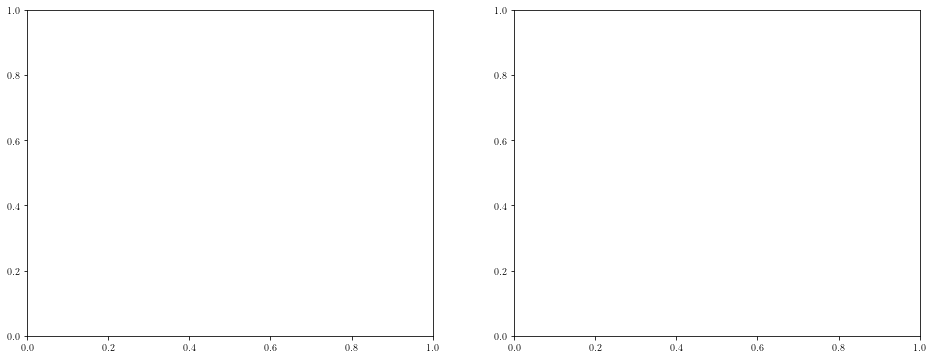

In [18]:
plt.rcParams['text.usetex'] = True

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

sub = 'miaoyining'

subRank = factor[(factor.subject == sub)]

c1 = 35
heats = subRank[subRank.seed == c1].pivot_table(index='class-1', columns='class-2', values='coef')
mask  = subRank[subRank.seed == c1].pivot_table(
    index='class-1', columns='class-2', values='correct')

sns.heatmap(heats, cmap='vlag', ax=ax1, vmax=1, vmin=0.5)
ax1.set_title('Codeset-1:%.2f'%subRank[subRank.seed == c1].accuracy.mean())

c2 = 81
heats = subRank[subRank.seed == c2].pivot_table(
    index='class-1', columns='class-2', values='coef')
mask  = subRank[subRank.seed == c2].pivot_table(
    index='class-1', columns='class-2', values='correct')

sns.heatmap(heats, cmap='vlag', ax=ax2,vmax=1,vmin=0.5)
ax2.set_title('Codeset-2:%.2f' % subRank[subRank.seed == c2].accuracy.mean())

ax1.set_xlabel('Class')
ax1.set_ylabel('Class')
ax2.set_xlabel('Class')
ax2.set_ylabel('Class')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(
    ['No.%s' % s for s in np.arange(-10, 50, 10)]))
ax1.yaxis.set_major_formatter(ticker.FixedFormatter(
    ['No.%s' % s for s in np.arange(-10, 50, 10)]))


ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_formatter(ticker.FixedFormatter(
    ['No.%s' % s for s in np.arange(-10, 50, 10)]))
ax2.yaxis.set_major_formatter(ticker.FixedFormatter(
    ['No.%s' % s for s in np.arange(-10, 50, 10)]))

# plt.tight_layout()
plt.suptitle('Two codeset options')

f.savefig('../images/contradict.png',dpi=400)

# Extract regression relation

In [60]:
from statsmodels.stats.weightstats import ttest_ind
import copy

reg = []

for sub in tqdm(factor.subject.unique()):

    subRank = factor[(factor.subject==sub)]

    for cv in subRank.cv.unique():

        for seed in subRank.seed.unique():
            s = subRank[(subRank.seed==seed)&(subRank.cv==cv)]
            score = s.accuracy.unique()[0]
            s = s.pivot_table(index='label-1',columns='label-2',values='coef')
            m = s.to_numpy()

            frames = []

            for i in np.arange(len(m)):
                d = m[i,i]
                m_ = copy.deepcopy(m)
                m_[i,i] = None

                _,p,_ = ttest_ind([d], m_[~np.isnan(m_)].flatten(), alternative='larger')
                
                f = pd.DataFrame({
                    'p':[p],
                    'cv':[cv],
                    'class':[i],
                    'seed':[seed],
                    'score':[score]
                })

                frames.append(f)

            frames = pd.concat(frames,ignore_index=True)
            frames['skew'] = frames.p.skew()
            frames['kurt'] = frames.p.kurt()
            frames['ave'] = frames.p.mean()
            frames['std'] = frames.p.std()
            frames['mp'] = frames['p']-frames['p'].mean()
            frames['zstd'] = frames['mp'].std()
            frames['subject'] = sub

            reg.append(frames)
reg = pd.concat(reg,ignore_index=True)
reg.head()


100%|██████████| 5/5 [01:39<00:00, 19.98s/it]


,p,cv,class,seed,score,skew,kurt,ave,std,mp,zstd,subject
0,0.291961,0,0,0,0.6,2.255971,5.154871,0.113567,0.164909,0.178394,0.164909,chenyuzhen
1,0.043587,0,1,0,0.6,2.255971,5.154871,0.113567,0.164909,-0.069980,0.164909,chenyuzhen
2,0.087736,0,2,0,0.6,2.255971,5.154871,0.113567,0.164909,-0.025831,0.164909,chenyuzhen
3,0.495420,0,3,0,0.6,2.255971,5.154871,0.113567,0.164909,0.381853,0.164909,chenyuzhen
4,0.010606,0,4,0,0.6,2.255971,5.154871,0.113567,0.164909,-0.102961,0.164909,chenyuzhen


0.383


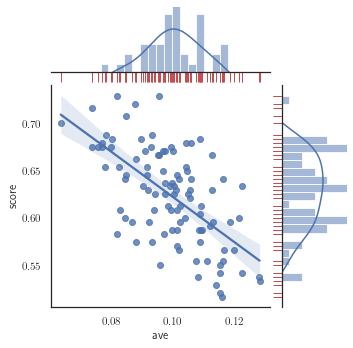

In [64]:
regAve = reg.groupby(['subject','seed'],as_index=False).mean()

regAve['s'] = regAve['std']/regAve['ave']
sns.set_theme(style='white')

sub = 'chenyuzhen'
from statsmodels.formula.api import ols
model1 = ols('ave ~ score', data=regAve[regAve.subject == sub]).fit(
    cov_type='HC3')

g = sns.jointplot(data=regAve[(regAve.subject.isin([sub]))], x="ave",
                  y="score", kind="reg", height=5, ratio=3, marginal_kws=dict(bins=25, fill=True),)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

print(round(model1.rsquared_adj, 3))

# Use TDCA

In [4]:
tdca = []
add = '../results/sweep'
subs = os.listdir(add)
subs.remove('.DS_Store')
saveFILE = 'tdca.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE
    if os.path.exists(s):
        # random
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        tdca.append(f)
        
tdca = pd.concat(tdca,ignore_index=True)
tdca.head()

,Unnamed: 0,class-1,class-2,coef,h,minmax,distance,label-1,label-2,seed,cv,accuracy,subject
0,0,0,0,0.286932,NaN,-0.917044,7.232747,118,118,0,0,0.375,group
1,1,1,0,0.508632,0.839453,-0.917044,7.232747,115,118,0,0,0.375,group
2,2,2,0,-0.048273,0.316619,-0.917044,7.232747,33,118,0,0,0.375,group
3,3,3,0,-0.221754,0.174905,-0.917044,7.232747,157,118,0,0,0.375,group
4,4,4,0,-0.269258,0.144494,-0.917044,7.232747,132,118,0,0,0.375,group


/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_74363/856884113.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_74363/856884113.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))


Text(0.5, 1.0, 'TDCA Classification Coef')

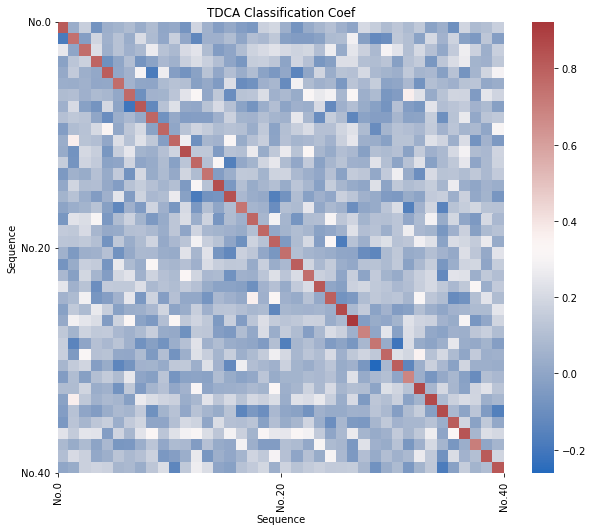

In [17]:
f,ax = plt.subplots(1,1,figsize=(10,8.3))

heats = tdca.pivot_table(index='label-1', columns='label-2', values='coef')
sns.heatmap(heats, cmap='vlag', ax=ax)


ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['No.%s'%s for s in np.arange(-20,180,20)]))

ax.set_xlabel('Sequence')
ax.set_ylabel('Sequence')

ax.set_title('TDCA Classification Coef')
# f.savefig('../images/160times160.png',dpi=400)

In [7]:
Ave = tdca.groupby(['subject','seed','class-1','class-2'],as_index=False).mean()
Ave['type'] = 'target'
Ave.loc[Ave['class-1']!=Ave['class-2'],'type']='distractor'
Ave.head()

,subject,seed,class-1,class-2,Unnamed: 0,coef,h,minmax,distance,label-1,label-2,cv,accuracy,type
0,chenyuzhen,0,0,0,2000000.0,0.861110,NaN,-1.006874,5.14271,70.833333,70.833333,2.5,0.333333,target
1,chenyuzhen,0,0,1,2000040.0,-0.396836,0.156101,-1.006874,5.14271,70.833333,75.500000,2.5,0.333333,distractor
2,chenyuzhen,0,0,2,2000080.0,0.217621,0.466213,-1.006874,5.14271,70.833333,86.333333,2.5,0.333333,distractor
3,chenyuzhen,0,0,3,2000120.0,0.240253,0.477324,-1.006874,5.14271,70.833333,86.000000,2.5,0.333333,distractor
4,chenyuzhen,0,0,4,2000160.0,0.206784,0.444293,-1.006874,5.14271,70.833333,77.333333,2.5,0.333333,distractor


/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_79621/3572047814.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(['%s'%s for s in np.arange(-10,41,10)]))
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_79621/3572047814.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(['%s'%s for s in np.arange(-10,41,10)]))


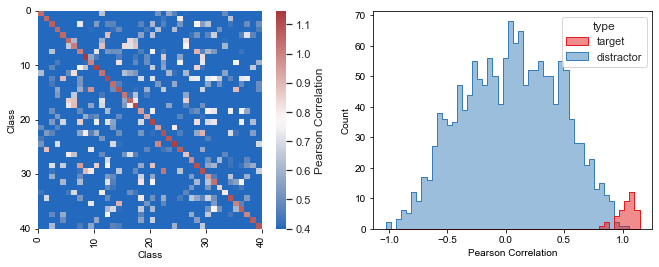

In [7]:
f, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.set_theme(style='white')

oneSeed = Ave[(Ave.subject=='miaoyining')&(Ave.seed==1)]
heat = oneSeed.pivot_table(columns='class-2',index='class-1',values='coef')
handle = sns.heatmap(data=heat,ax=ax[0],cmap='vlag',vmin=0.4,cbar_kws={'label':'Pearson Correlation'})

sns.histplot(data=oneSeed, x='coef',hue='type',palette='Set1',alpha=0.5,ax=ax[1],bins=50,element='step')

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(['%s'%s for s in np.arange(-10,41,10)]))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(['%s'%s for s in np.arange(-10,41,10)]))

ax[0].set_xlabel('Class')
ax[0].set_ylabel('Class')

ax[1].set_xlabel('Pearson Correlation')

f.savefig('../images/illustrate.png',dpi=300)

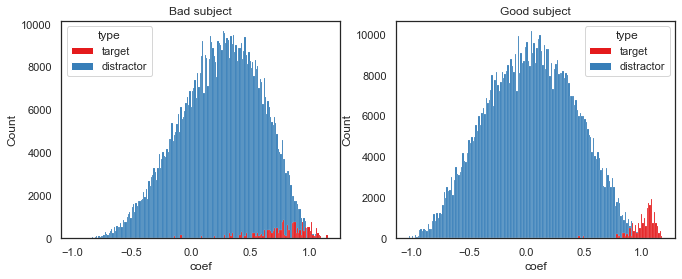

In [63]:
f,ax = plt.subplots(1,2,figsize=(11,4))
sns.set_theme(style='white')

sub = 'chenyuzhen'
sns.histplot(data=Ave[(Ave.subject==sub)], x='coef',hue='type',palette='Set1',alpha=1,ax=ax[0])
ax[0].set_title('Bad subject')

sub = 'miaoyining'
sns.histplot(data=Ave[(Ave.subject==sub)], x='coef',hue='type',palette='Set1',alpha=1,ax=ax[1])
ax[1].set_title('Good subject')

f.savefig('../images/good&bad.png',dpi=300)

In [128]:
sub = 'shinanlin'
subAve = Ave[Ave.subject==sub]
subAve.groupby(by=['seed'],as_index=False).mean().sort_values(by='accuracy',ascending=False)[['seed','accuracy']]

,seed,accuracy
241,241,0.679167
269,269,0.679167
448,448,0.679167
355,355,0.670833
324,324,0.670833
...,...,...
414,414,0.475000
54,54,0.458333
78,78,0.458333
39,39,0.450000


<AxesSubplot:xlabel='coef', ylabel='Density'>

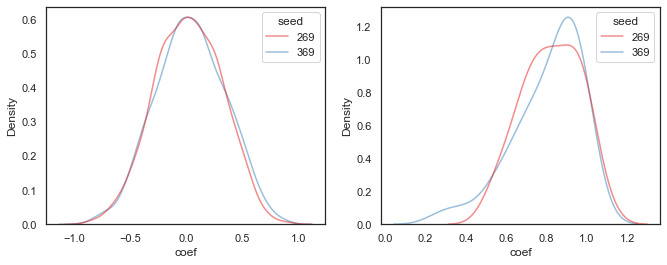

In [129]:
f,ax = plt.subplots(1,2,figsize=(11,4))

seed = [269, 369]

sns.kdeplot(data=subAve[(subAve.seed.isin(seed) & (
    subAve.type == 'distractor'))], x='coef', hue='seed', palette='Set1', alpha=0.5, ax=ax[0],hue_order=seed)

sns.kdeplot(data=subAve[(subAve.seed.isin(seed) & (
    subAve.type == 'target'))], x='coef', hue='seed', palette='Set1', alpha=0.5, ax=ax[1], hue_order=seed)

Text(0.5, 1.0, 'Coef')

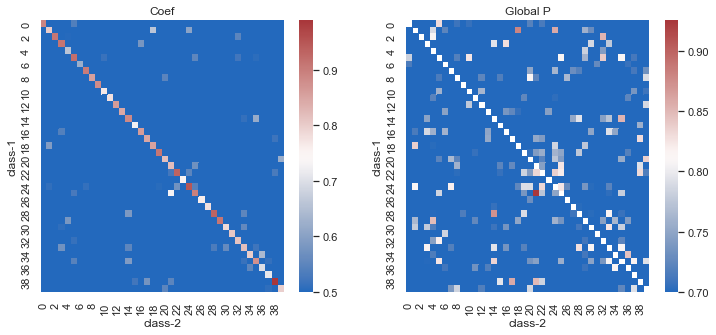

In [7]:
f,ax = plt.subplots(1,2,figsize=(12,5))

i = 9

heats = tdca[tdca.seed==i].pivot_table(index='class-1', columns='class-2', values='coef')
sns.heatmap(heats, cmap='vlag', ax=ax[0],vmin=0.5)

heats = tdca[tdca.seed==i].pivot_table(index='class-1', columns='class-2', values='h')
sns.heatmap(heats, cmap='vlag', ax=ax[1],vmin=0.7)

ax[1].set_title('Global P')
ax[0].set_title('Coef')

In [16]:
seedAve = Ave.groupby(by=['subject','seed'],as_index=False).mean()

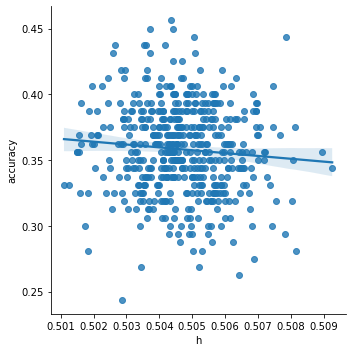

In [15]:
sns.lmplot(data=seedAve[seedAve.subject=='group'], x='h', y='accuracy')